https://www.kaggle.com/c/titanic

Competition Description

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

Practice Skills
Binary classification
Python and R basics

Variable Notes

survival:	Survival	0 = No, 1 = Yes

<br>pclass: Ticket class:A proxy for socio-economic status (SES)
<br>1st = Upper
<br>2nd = Middle
<br>3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: # of siblings / spouses aboard the Titanic
<br>The dataset defines family relations in this way...
<br>Sibling = brother, sister, stepbrother, stepsister
<br>Spouse = husband, wife (mistresses and fiancés were ignored)

<br>parch: # of parents / children aboard the Titanic
<br>The dataset defines family relations in this way...
<br>Parent = mother, father
<br>Child = daughter, son, stepdaughter, stepson
<br>Some children travelled only with a nanny, therefore parch=0 for them.

embarked:port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import time

#setting for plot fonts 
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#display notebook in full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.options.mode.chained_assignment = None  # default='warn'

random_state = 42

### Read Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Train shape {} Test Shape{}'.format(train.shape, test.shape))
train.head()

Train shape (891, 12) Test Shape(418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Missing Data
Its important to find null values in data so that we can impute(replace) them as many ML alogorthms cant handle missing values.
Column Cabin has 77% of misisng values 


In [3]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent= (data.isnull().sum() * 100 / data.isnull().count() ).sort_values(ascending = False)
    df = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    return df[df['Total'] != 0]



In [4]:
missing_data(train)

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


### Prepare Numeric and  Categorical columns

In [5]:
all_cols = train.columns.tolist()
print(all_cols)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [6]:
num_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat_cols = [ 'Sex', 'Ticket', 'Cabin', 'Embarked']
features = num_cols + cat_cols
print(features)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Ticket', 'Cabin', 'Embarked']


### Target value exploration
Here target is column Survived which we need to predict in test data. We can see that around 62% of passenegers died while 38% of passengers survived. This also helps us to guage the performance of our model. A random model which allways predicts that all passengers died will be have accuracy of 62%. Our model needs to perform better than that to have any meaningful predictions. We will aim to achieve more than 80% accuracy which is a good relative performance

In [7]:
def display_survival_data(df):
    
    sns.countplot(df.target_name)
    plt.title('Titanic passenger survival')
    plt.xlabel('Passenger Survived?', fontsize =  12)
    plt.ylabel('Number of occurenecs', fontsize =  12)
    plt.show()

    total = df.Survived.count()
    total_0 = df['Survived'][df.Survived == 0].count()
    total_1 =  df['Survived'][df.Survived == 1].count()

    class_0_perc = total_0/total
    class_1_perc = 1 - class_0_perc
    print('% passengers died: {:.3%}'.format(class_0_perc))
    print('% passengers survived: {:.3%}'.format(class_1_perc))
    


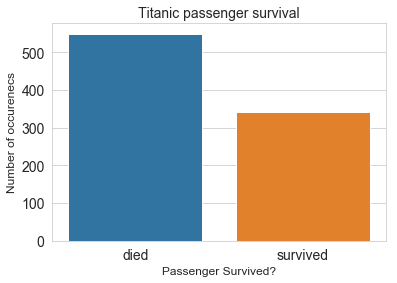

% passengers died: 61.616%
% passengers survived: 38.384%


In [8]:
train['target_name'] = train['Survived'].map({0: 'died', 1: 'survived'})
display_survival_data(train)

### Correlation For Numeric variables
Lets us check if there is correlation in numeric features 

We can see Pclass is negatively correlated with Fare meaning higher the class higher the fare. Note that here Pclass 1 is higher than Pclass 2 hence negative correlation

In [9]:

def display_correlation(df):
    cor_matrix = df.corr().round(2)
    # Plotting heatmap     
    fig = plt.figure(figsize=(6, 6));
    plt.title('correlation matrix')
    sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
    plt.show()
    


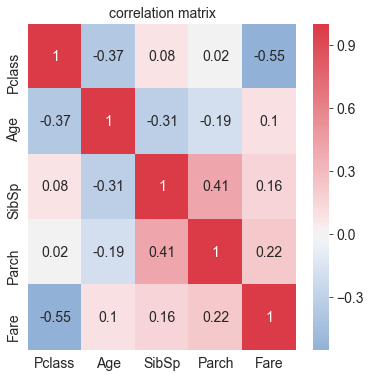

In [10]:
display_correlation(train[num_cols])

### Numeric features statistics
<br>Median Age of passengers in 28
<br>Maximum number of siblings or spouses(SibSp) travelling along a passengers is 8

In [11]:
train[num_cols].describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


### Cardinality of variables
Lets check how many unique values all features have.

In [12]:
def print_cardinality(df, cols):
    for col in cols:
        dist_vals = df[col].value_counts().shape[0]
        print('Column:{}, Number of distict Values:{}'.format(col, dist_vals))



In [13]:
print_cardinality(train, all_cols)

Column:PassengerId, Number of distict Values:891
Column:Survived, Number of distict Values:2
Column:Pclass, Number of distict Values:3
Column:Name, Number of distict Values:891
Column:Sex, Number of distict Values:2
Column:Age, Number of distict Values:88
Column:SibSp, Number of distict Values:7
Column:Parch, Number of distict Values:7
Column:Ticket, Number of distict Values:681
Column:Fare, Number of distict Values:248
Column:Cabin, Number of distict Values:147
Column:Embarked, Number of distict Values:3


## Plot  Discrete Features

In [14]:
def plot_discrete_feature(df, col ):  
   
    fig, ax = plt.subplots(figsize =(24, 6))  
   
#   plot the count for each value
    sns.countplot(x = col,  data = df, ax= plt.subplot(131))

    #Plot survival  occurances for value
    ax = sns.countplot(x = col, hue = 'target_name', data = df, ax = plt.subplot(132))
    plt.xlabel(col, fontsize = 14)
    plt.ylabel('Count', fontsize = 14)
    # Title for whole figure
    plt.suptitle('Plots for ' +col, fontsize = 18)

    # Show percentages of pasengers survived
    sns.pointplot(x = col, y= 'Survived', data = df, ax = plt.subplot(133))
    # X-axis Label
    plt.xlabel(col, fontsize=14);
    # Y-axis Label
    plt.ylabel('Survived %', fontsize=14);
    plt.show()

### plots for passengers class

We can clearly see that pasengers belonging to higher class had better survival rate.
Survival rate of passengers belonging to upper class(Pclass = 1) is around 62% while those in lower class(Pclass = 3)  had only 25% survival rate.

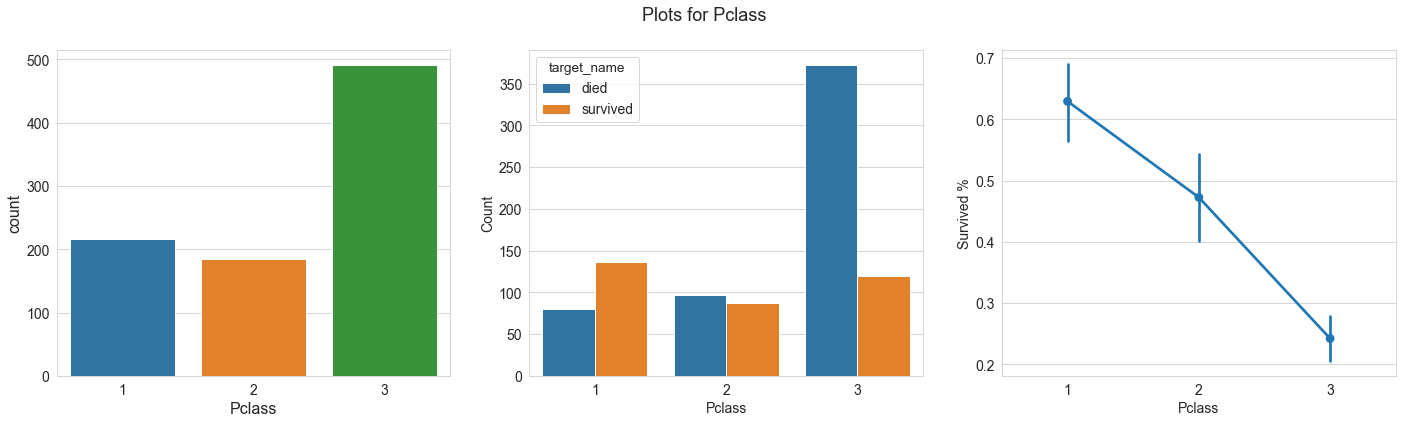

In [15]:
plot_discrete_feature(train, 'Pclass')

### plots for passengers sex
72% of female passengers survived while only 19% of males survived, The article dicusses this observation along with the class based survival which we saw earlier
https://www.washingtonpost.com/opinions/women-and-children-did-go-first-on-titanic/2012/04/19/gIQAgSaugT_story.html?noredirect=on&utm_term=.341673775648

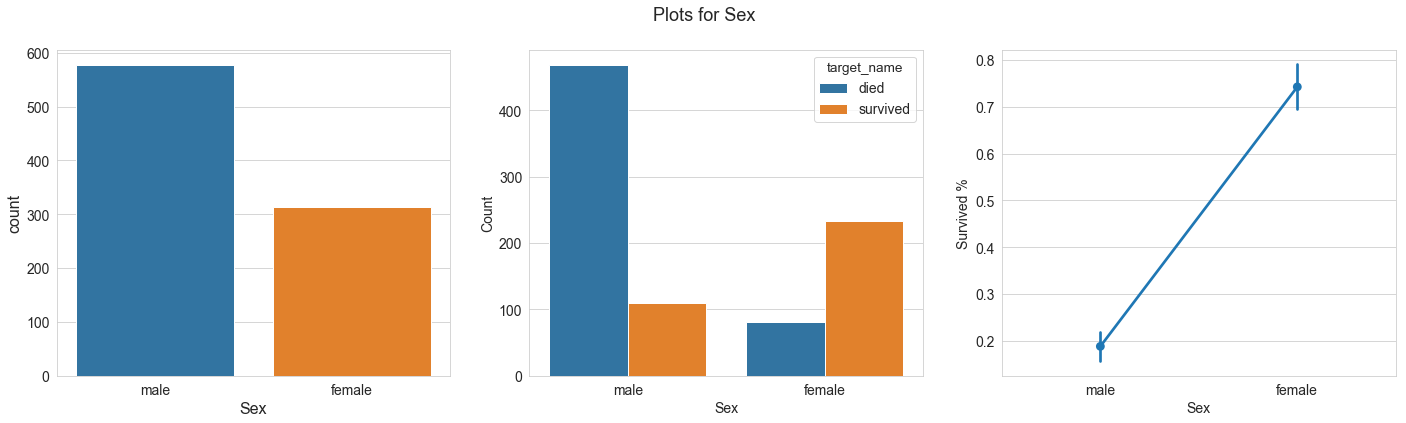

In [16]:
plot_discrete_feature(train, 'Sex')

### Plots for  Count of siblings / spouses
Maximum passengers had no siblings or spouses.
Passengers with 1 sibling or spouse had best survival rate  of 53%

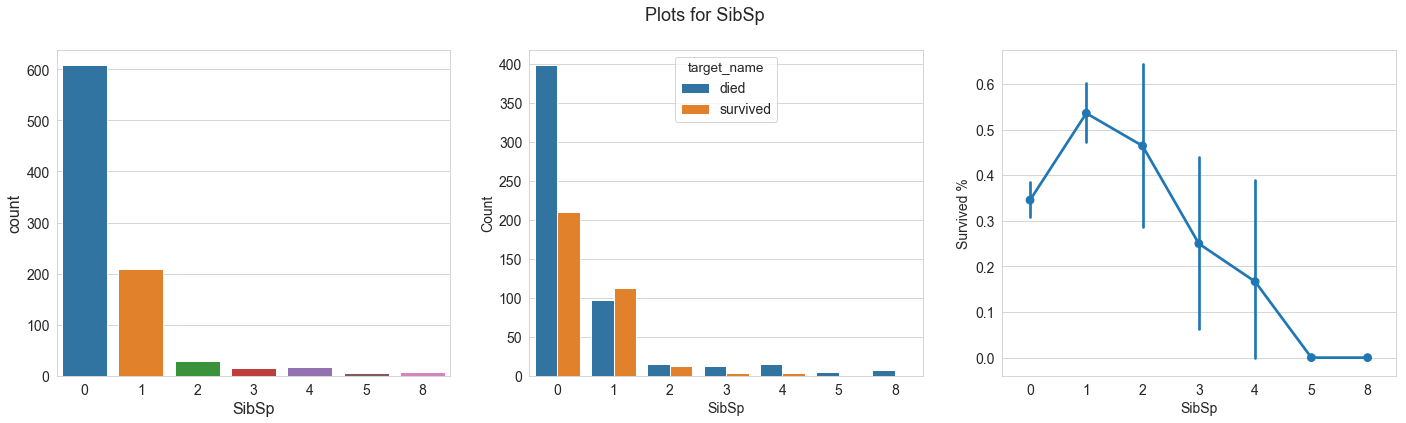

In [17]:
plot_discrete_feature(train, 'SibSp')

### Plots for Count of  parents/Children
Maximum passengers were travelling without children or parents

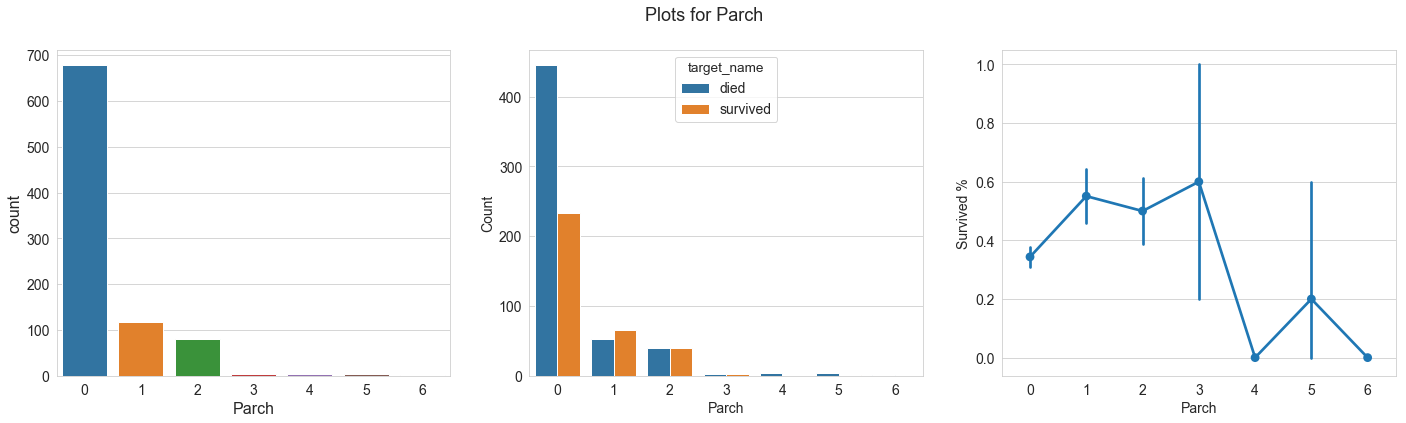

In [18]:
plot_discrete_feature(train, 'Parch')

#### Plots for port of Embarkation 
Maximum passengers embarked from Southampton and their survical rate was also lowest around 34%

Passengers who embarked from Cherbourg had highest survival rate of 55%

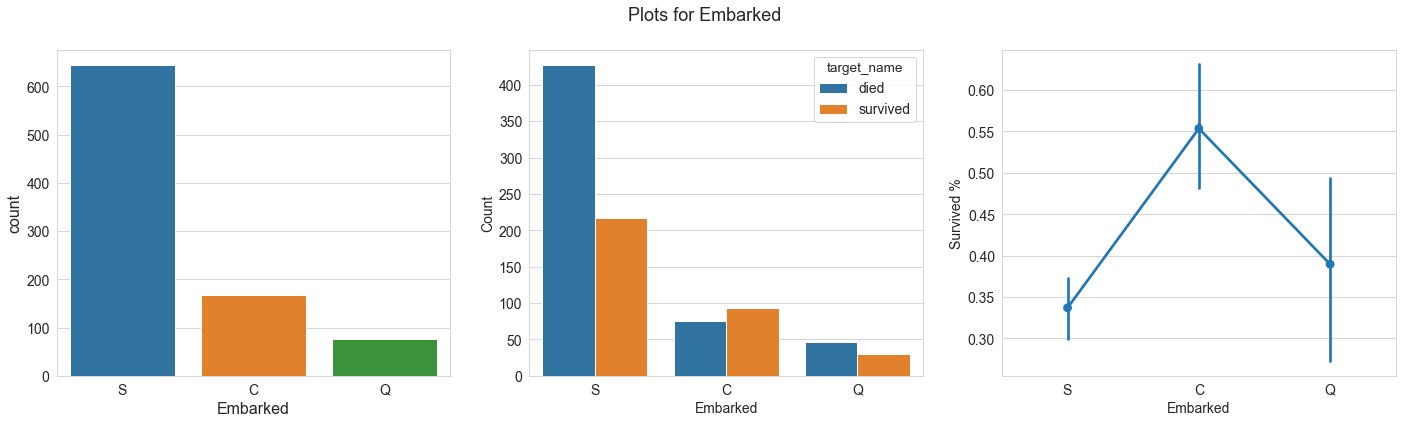

In [19]:
plot_discrete_feature(train, 'Embarked')

## Display Continous Features

In [20]:

def display_continous_features(df, col):
    df = df[[col, 'Survived', 'target_name']].copy()
    df.dropna(subset=[col], inplace =True)

    fig = plt.figure(figsize=(16, 10)) 
    #Display Density Plot
    sns.distplot(df[col], color = 'b',  ax = plt.subplot(221)  )
    plt.ylabel('Density')


    #Display Density Plot for survived vs died
    sns.distplot(df[df['Survived'] == 0][col], color = 'r', label = 'died', ax = plt.subplot(222)  )
    sns.distplot(df[df['Survived'] == 1][col], color = 'b', label = 'survived', ax = plt.subplot(222))
    plt.legend(loc = 'best')
    plt.ylabel('Density survival vs died')

#   Display Box Plot for feature
    sns.boxplot(x = col , data = df, ax = plt.subplot(223))
    
#     Display Violin Plot for survived vs died
    sns.violinplot(x = col , y = 'target_name', data = train, ax = plt.subplot(224))
    plt.show()

### Plots for Age
Children under age 5 had better survival rate while those between 15 to 30 had worse survival rate

The box plot interpretation can be checked at https://en.wikipedia.org/wiki/Interquartile_range#/media/File:Boxplot_vs_PDF.svg

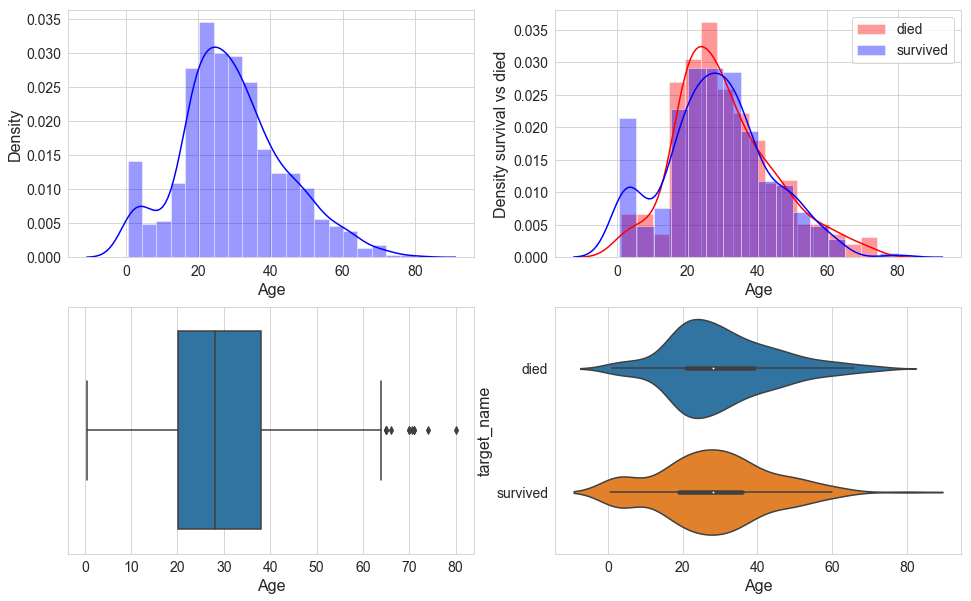

In [21]:
display_continous_features(train, 'Age')

### Plots for Fare
There are some outiers for fares as shown by black spots on box plot.
Passengers who paid higher fare were more liklely to survive.


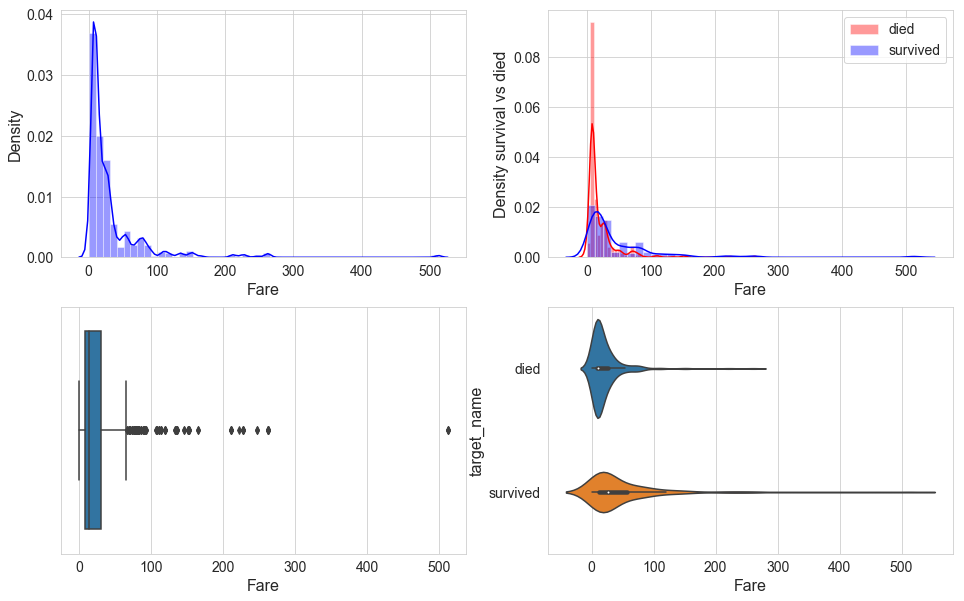

In [22]:
display_continous_features(train, 'Fare')

# Data Pre-Processing

### Split Data into Training and Validation Sets

In [23]:
from sklearn.model_selection import train_test_split
X  = train[features].copy()
y  = train['Survived']
X_test = test[features].copy()

X_train, X_valid, y_train, y_valid  = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = random_state)
print('Training Shape {}, Validation shape {}, Test Shape {}'.format(X_train.shape, X_valid.shape, X_test.shape))

Training Shape (668, 9), Validation shape (223, 9), Test Shape (418, 9)


### Impute Missing Values

In [24]:
missing_data(X_train)

,Total,Percent
Cabin,522,78.143713
Age,131,19.610778
Embarked,2,0.299401


In [25]:
from sklearn.impute import  SimpleImputer

#replace misisng values for Cabin by NA
X_train['Cabin'].fillna('NA', inplace = True)
X_valid['Cabin'].fillna('NA', inplace = True)
X_test['Cabin'].fillna('NA', inplace = True)

#Replace missing values for Embarked as mode
imp_mode = SimpleImputer(strategy = 'most_frequent')
X_train['Embarked'] = imp_mode.fit_transform(X_train['Embarked'].values.reshape(-1,1))
X_valid['Embarked'] = imp_mode.transform(X_valid['Embarked'].values.reshape(-1,1))
X_test['Embarked']  = imp_mode.transform(X_test['Embarked'].values.reshape(-1,1))

#Replace missing values for Age by Median
imp_median = SimpleImputer(strategy= 'median')
X_train['Age'] = imp_median.fit_transform(X_train['Age'].values.reshape(-1,1))
X_valid['Age'] = imp_median.fit_transform(X_valid['Age'].values.reshape(-1,1))
X_test['Age']  = imp_median.fit_transform(X_test['Age'].values.reshape(-1,1))

#Replace Fare in test set by 0
X_test['Fare']  = imp_median.fit_transform(X_test['Fare'].values.reshape(-1,1))

In [26]:
missing_data(X_train)

,Total,Percent


### One Hot Encode categorical features
We will be using  library category_encoders for one hot encoding: http://contrib.scikit-learn.org/categorical-encoding/#. This page also have installation for the package using conda command

If you have scikit-learn v0.20.0 its recommneded to use OneHotEncoder:http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [27]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex,Ticket,Cabin,Embarked
486,1,35.0,1,0,90.000,female,19943,C93,S
238,2,19.0,0,0,10.500,male,28665,NA,S
722,2,34.0,0,0,13.000,male,12233,NA,S
184,3,4.0,0,2,22.025,female,315153,NA,S
56,2,21.0,0,0,10.500,female,C.A. 31026,NA,S


In [28]:
import category_encoders as ce
ohe = ce.OneHotEncoder(cols = cat_cols, drop_invariant= True, use_cat_names = True)
X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)
X_test = ohe.transform(X_test)

In [29]:
print('Training Shape {}, Validation shape {}, Test Shape {}'.format(X_train.shape, X_valid.shape, X_test.shape))
X_train.head()

Training Shape (668, 673), Validation shape (223, 673), Test Shape (418, 673)


,Sex_female,Sex_male,Ticket_19943,Ticket_28665,Ticket_12233,Ticket_315153,Ticket_C.A. 31026,Ticket_113773,Ticket_3101295,Ticket_A/5. 3336,...,Cabin_C86,Cabin_E63,Embarked_S,Embarked_C,Embarked_Q,Pclass,Age,SibSp,Parch,Fare
486,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,35.0,1,0,90.000
238,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,2,19.0,0,0,10.500
722,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,2,34.0,0,0,13.000
184,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,3,4.0,0,2,22.025
56,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,2,21.0,0,0,10.500


### Normalize Numeric Data

In [30]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train[num_cols] =  sc.fit_transform(X_train[num_cols])
X_valid[num_cols] =  sc.transform(X_valid[num_cols])
X_test[num_cols] =  sc.transform(X_test[num_cols])

C:\Users\I056036\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\I056036\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\I056036\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\I056036\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [31]:
X_train[num_cols].head()

,Pclass,Age,SibSp,Parch,Fare
486,-1.579334,0.405333,0.536677,-0.451483,1.240397
238,-0.376375,-0.829764,-0.464720,-0.451483,-0.436028
722,-0.376375,0.328140,-0.464720,-0.451483,-0.383310
184,0.826584,-1.987668,-0.464720,1.951631,-0.192999
56,-0.376375,-0.675377,-0.464720,-0.451483,-0.436028


## Model Training Utilities

In [32]:
from sklearn.metrics import accuracy_score
def print_logs(model):
    print('Validation Accuracy %0.5f' % accuracy_score(y_valid, y_pred_val))
    print('Training Shape {}, Validation shape {}, Test Shape {}'.format(X_train.shape, X_valid.shape, X_test.shape))
    print(model.get_params())

def write_sub(y_pred, filename):    
    sub = pd.DataFrame()
    sub['PassengerId'] = test['PassengerId']
    sub['Survived'] = y_pred
    sub.to_csv(filename, index = False)

## Random Forest

### Random Forest Baseline

In [33]:
from sklearn.ensemble import RandomForestClassifier

#Train Model
model = RandomForestClassifier(random_state = random_state, n_estimators= 100)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print('Training Accuracy %0.5f' %accuracy_score(y_train, y_pred))

#Predict on Validation set
y_pred = model.predict(X_valid)
print('Validation Accuracy %0.5f' % accuracy_score(y_valid, y_pred))


Training Accuracy 1.00000
Validation Accuracy 0.80269


### Random Forest: Tuned
This Model having validation accuracy 0.83408 will have Test accuracy  accuracy of 0.78947 on test data when submitted in Kaggle. Since we are using 75% of training data rest being used for validation, we can improve the accuracy by using Full training data and usin K-Fold Cross Validation 

#### Train The Model

In [34]:
#Train Model
model = RandomForestClassifier(      n_estimators = 110,
                                     max_depth   = 200,
                                     max_leaf_nodes = 172,
                                     min_samples_leaf = 1,
                                     max_features = 'sqrt',
                                     criterion = 'entropy',                                
                                     bootstrap = True,
                                     random_state = random_state,
                                     class_weight = None,
                                     n_jobs = 4
                                      )

model.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=200, max_features='sqrt', max_leaf_nodes=172,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=110, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#### Predict on Training and Validation set

In [35]:
y_pred = model.predict(X_train)
print('Training Accuracy %0.5f' %accuracy_score(y_train, y_pred))

#Predict on Validation set
y_pred_val = model.predict(X_valid)
print('Validation Accuracy %0.5f' % accuracy_score(y_valid, y_pred_val))

Training Accuracy 0.98054
Validation Accuracy 0.83408


#### Predict on test set and write submission file
Go to https://www.kaggle.com/c/titanic and submit your predictions to check your accuracy score

In [36]:
#predict on test set and write submissions to file
y_pred = model.predict(X_test)
write_sub(y_pred, 'rf_sub.csv')

In [37]:
print_logs(model)

Validation Accuracy 0.83408
Training Shape (668, 673), Validation shape (223, 673), Test Shape (418, 673)
{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 200, 'max_features': 'sqrt', 'max_leaf_nodes': 172, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 110, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
